## Domain Adaptation Run

In this notebook, we run domain adaption (DA) in addition to mean-variance estimation (MVE). This is MVE-UDA. All notebooks are identical, except for 2 changes, as specified below.

**NOTE:**  
SEED - Seed will change between Runs (Run A, B, C, D, E), but is consistent across MVE-only and MVE-UDA.  
DA Weight - DA Weight is 1.4 for MVE-UDA runs. DA Weight is 0.0 for MVE-only runs.

In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Set Seed

Seed is set according to run index. Specifically,
* Run A: Seed 56
* Run B: Seed 11
* Run C: Seed 31
* Run D: Seed 6
* Run E: Seed 63

In [2]:
#fix seed
seed = 63
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

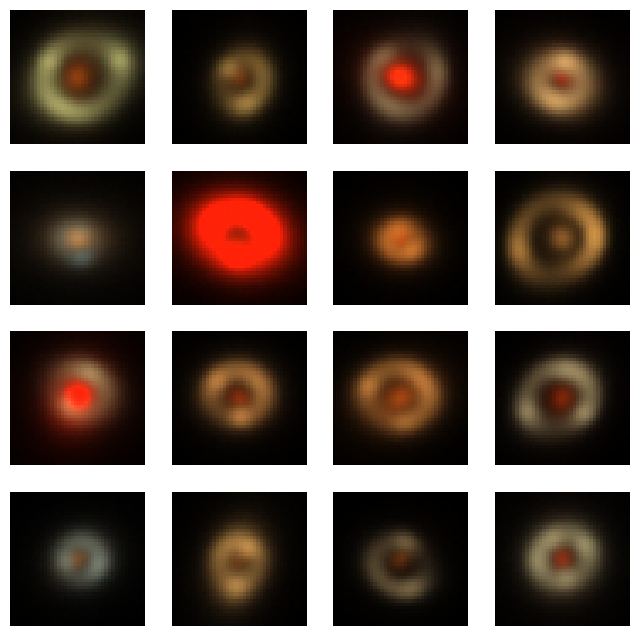

In [4]:
# Visualize source data
visualize_data(source_data)

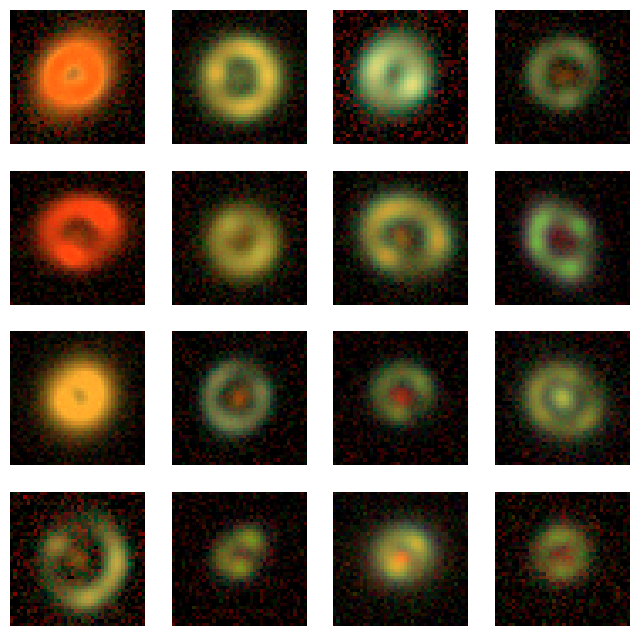

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

DA Weight is set according to MVE-Only or MVE-UDA run. Specifically,  
* MVE-UDA: DA Weight = constant 1.4
* MVE-only: DA Weight = constant 0.0, i.e. NO DA Loss

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    # if epoch < evolv_epoch:
    #     da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    # else:
    #     da_weight = final_wt_da
    return 1.4

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    # if epoch < evolv_epoch:
    #     beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch)
    # else:
    #     beta_val = beta_final
    return 0.5

# Initialize hyperparameters
n_epoch = 150


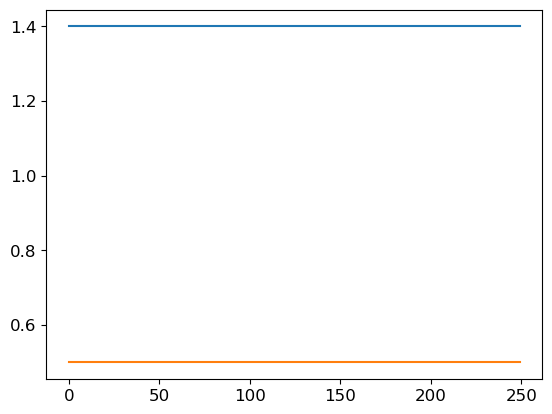

In [7]:
s = np.arange(250)
plt.plot(s, [da_weight_function(i) for i in s])
plt.plot(s, [beta_function(i) for i in s])

### Initialize the Model

Model architecture (MVEv3) is identical to architecture in the paper and summarized below.

In [8]:
# Initialize model
model = NeuralNetworkMVEv3(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.AdamW(model.parameters())

In [9]:
from torchsummary import summary
summary(model, (3, 40, 40))

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]             224
              ReLU-2            [-1, 8, 40, 40]               0
       BatchNorm2d-3            [-1, 8, 40, 40]              16
         MaxPool2d-4            [-1, 8, 20, 20]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              ReLU-6           [-1, 16, 20, 20]               0
       BatchNorm2d-7           [-1, 16, 20, 20]              32
         MaxPool2d-8           [-1, 16, 10, 10]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             ReLU-10           [-1, 32, 10, 10]               0
      BatchNorm2d-11           [-1, 32, 10, 10]              64
        MaxPool2d-12             [-1, 32, 5, 5]               0
           Linear-13                  [-1, 128]         102,528
          Sigmoid-14                  [

### Initialize Model State

If loading a paused run, enter a `load_mod_name`. If not, leave None, and the state will be initialized automatically.  
`save_mod_name` describes what root name models will be saved under during training.

In [10]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None 
stats, model, optimizer, best_target_R2, best_mve_loss, best_nll_loss, best_snll_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/RunE"

## Train

Beginning Training...
Generating Isomap...


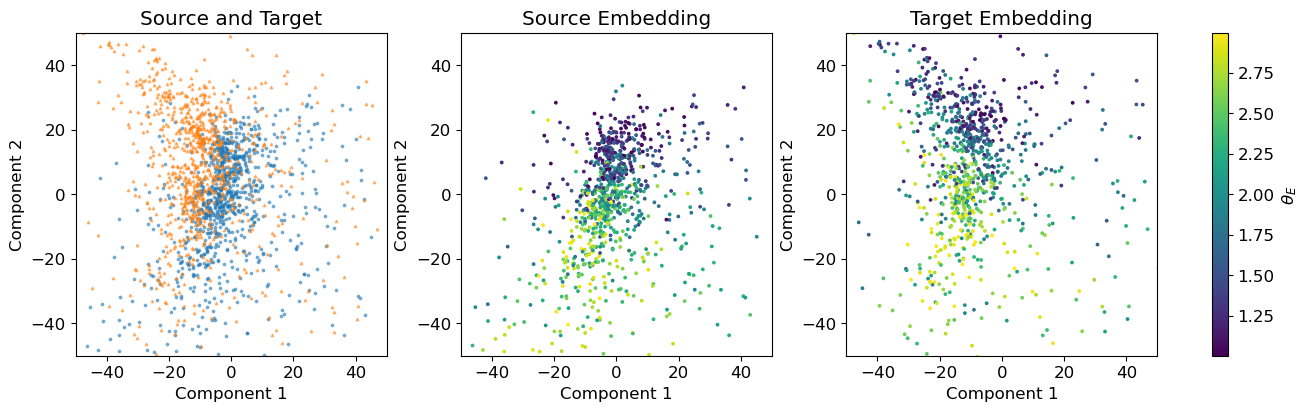

Saving Model... Done.

Epoch 0: 57.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0402
	Train Regression Loss: : 0.1332
	Train Mve Loss: : -0.1438
	Train R2 Score: : 0.5959
 Validation Statistics:
	Val Source Regression Loss: : 0.0154
	Val Target Regression Loss: : 0.0171
	Val Source R2 Score: : 0.9526
	Val Target R2 Score: : 0.9491
	Val Source Mve Loss: : -0.2613
	Val Target Mve Loss: : -0.2565
	Val Source Nll Loss: : -1.4491
	Val Target Nll Loss: : -1.4216
Saving Model... Done.
Saving Model MVE... Done.
Saving Model NLL... Done.
Saving Model SNLL... Done.

Epoch 1: 70.06s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0404
	Train Regression Loss: : 0.0260
	Train Mve Loss: : -0.2330
	Train R2 Score: : 0.9208
 Validation Statistics:
	Val Source Regression Loss: : 0.0221
	Val Target Regression Loss: : 0.0260
	Val Source R2 Score: : 0.9325
	Val Target R2 Score: : 0.9225
	Val Source Mve Loss: : 0.2128
	Val Target Mve Loss: : 0.2911

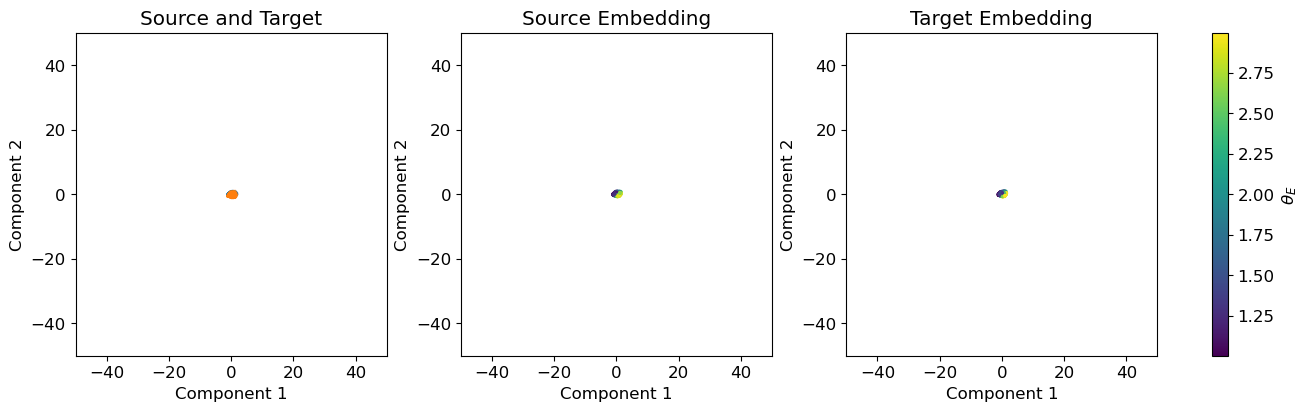

Saving Model... Done.

Epoch 20: 71.18s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0403
	Train Regression Loss: : 0.0208
	Train Mve Loss: : -0.3390
	Train R2 Score: : 0.9371
 Validation Statistics:
	Val Source Regression Loss: : 0.0178
	Val Target Regression Loss: : 0.0209
	Val Source R2 Score: : 0.9456
	Val Target R2 Score: : 0.9381
	Val Source Mve Loss: : -0.3436
	Val Target Mve Loss: : -0.3394
	Val Source Nll Loss: : -0.9049
	Val Target Nll Loss: : -0.8934

Epoch 21: 85.88s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0404
	Train Regression Loss: : 0.0177
	Train Mve Loss: : -0.3406
	Train R2 Score: : 0.9465
 Validation Statistics:
	Val Source Regression Loss: : 0.0171
	Val Target Regression Loss: : 0.0192
	Val Source R2 Score: : 0.9474
	Val Target R2 Score: : 0.9423
	Val Source Mve Loss: : -0.3350
	Val Target Mve Loss: : -0.3316
	Val Source Nll Loss: : -1.0815
	Val Target Nll Loss: : -1.0705

Epoch 22: 93.25s
--------------

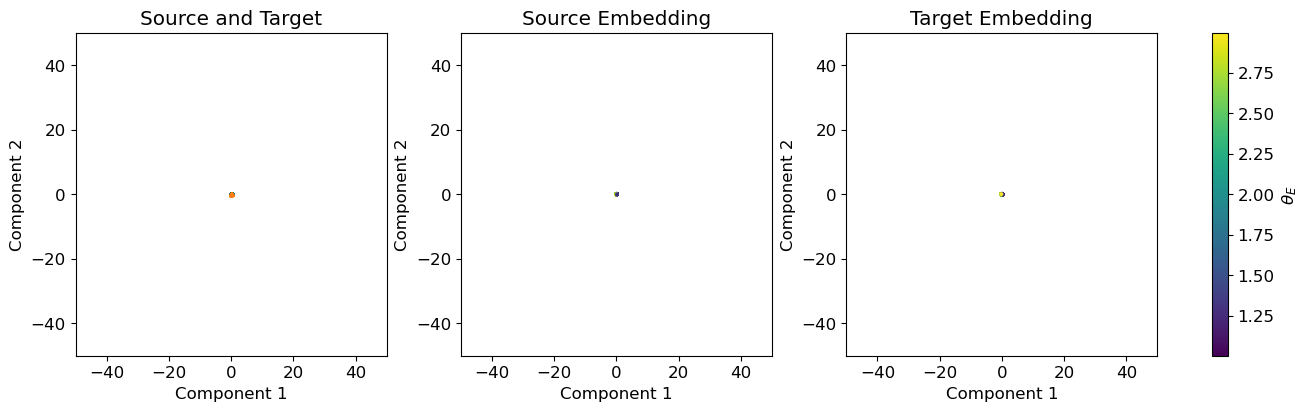

Saving Model... Done.

Epoch 40: 83.76s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0414
	Train Regression Loss: : 0.0102
	Train Mve Loss: : -0.3000
	Train R2 Score: : 0.9691
 Validation Statistics:
	Val Source Regression Loss: : 0.0058
	Val Target Regression Loss: : 0.0070
	Val Source R2 Score: : 0.9823
	Val Target R2 Score: : 0.9792
	Val Source Mve Loss: : -0.2238
	Val Target Mve Loss: : -0.2188
	Val Source Nll Loss: : -1.9397
	Val Target Nll Loss: : -1.8980

Epoch 41: 80.88s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0408
	Train Regression Loss: : 0.0076
	Train Mve Loss: : -0.1803
	Train R2 Score: : 0.9769
 Validation Statistics:
	Val Source Regression Loss: : 0.0046
	Val Target Regression Loss: : 0.0056
	Val Source R2 Score: : 0.9859
	Val Target R2 Score: : 0.9832
	Val Source Mve Loss: : -0.1686
	Val Target Mve Loss: : -0.1622
	Val Source Nll Loss: : -2.1715
	Val Target Nll Loss: : -2.0893

Epoch 42: 52.84s
--------------

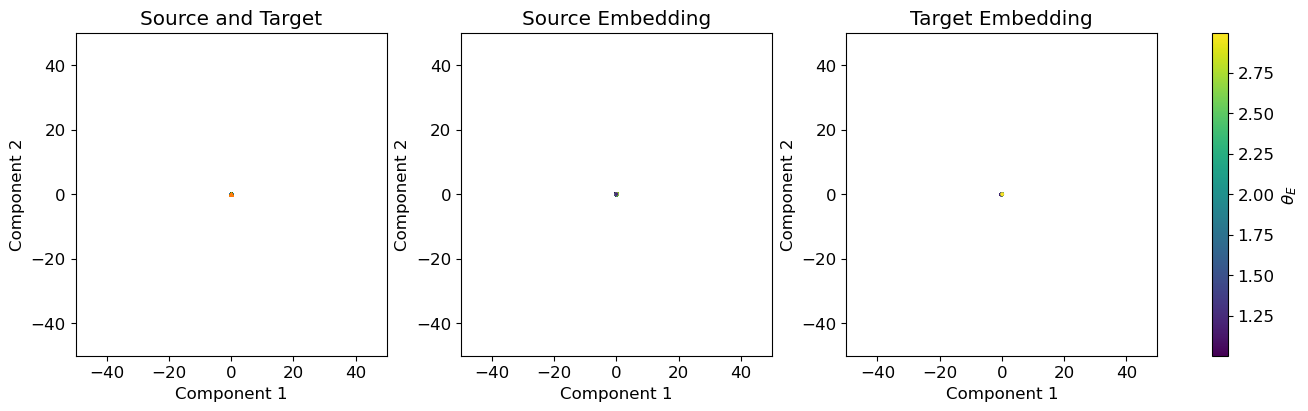

Saving Model... Done.

Epoch 60: 66.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0421
	Train Regression Loss: : 0.0074
	Train Mve Loss: : -0.1836
	Train R2 Score: : 0.9777
 Validation Statistics:
	Val Source Regression Loss: : 0.0048
	Val Target Regression Loss: : 0.0074
	Val Source R2 Score: : 0.9854
	Val Target R2 Score: : 0.9774
	Val Source Mve Loss: : -0.2340
	Val Target Mve Loss: : -0.2235
	Val Source Nll Loss: : -1.9621
	Val Target Nll Loss: : -1.8773

Epoch 61: 63.24s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0404
	Train Regression Loss: : 0.0075
	Train Mve Loss: : -0.2286
	Train R2 Score: : 0.9772
 Validation Statistics:
	Val Source Regression Loss: : 0.0046
	Val Target Regression Loss: : 0.0071
	Val Source R2 Score: : 0.9859
	Val Target R2 Score: : 0.9788
	Val Source Mve Loss: : -0.1930
	Val Target Mve Loss: : -0.1793
	Val Source Nll Loss: : -2.1199
	Val Target Nll Loss: : -1.9687

Epoch 62: 70.80s
--------------

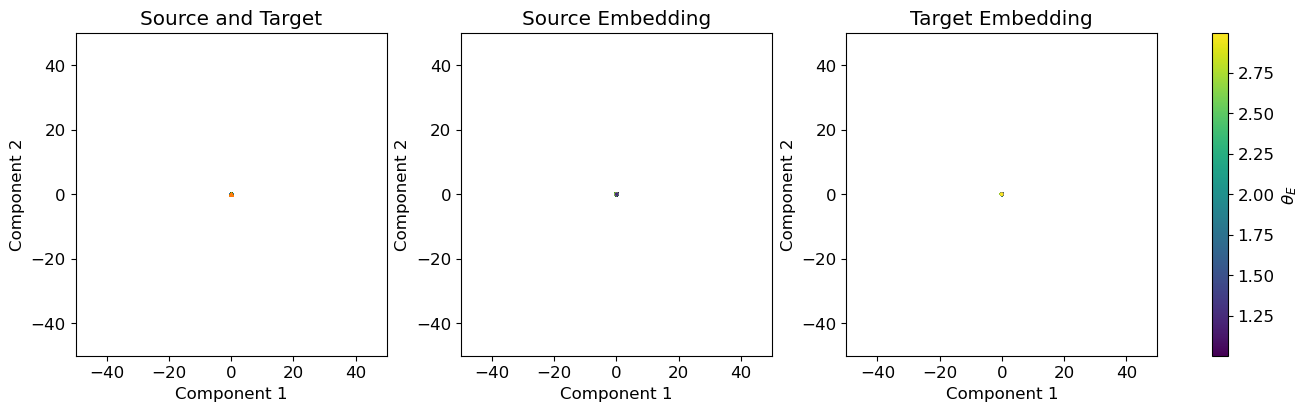

Saving Model... Done.

Epoch 80: 69.90s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0407
	Train Regression Loss: : 0.0064
	Train Mve Loss: : -0.1847
	Train R2 Score: : 0.9805
 Validation Statistics:
	Val Source Regression Loss: : 0.0032
	Val Target Regression Loss: : 0.0047
	Val Source R2 Score: : 0.9901
	Val Target R2 Score: : 0.9860
	Val Source Mve Loss: : -0.1945
	Val Target Mve Loss: : -0.1861
	Val Source Nll Loss: : -2.2266
	Val Target Nll Loss: : -2.1306
Saving Model... Done.
Saving Model NLL... Done.

Epoch 81: 83.20s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0421
	Train Regression Loss: : 0.0058
	Train Mve Loss: : -0.1898
	Train R2 Score: : 0.9823
 Validation Statistics:
	Val Source Regression Loss: : 0.0055
	Val Target Regression Loss: : 0.0077
	Val Source R2 Score: : 0.9832
	Val Target R2 Score: : 0.9764
	Val Source Mve Loss: : -0.1462
	Val Target Mve Loss: : -0.1304
	Val Source Nll Loss: : -2.0964
	Val Target Nll 

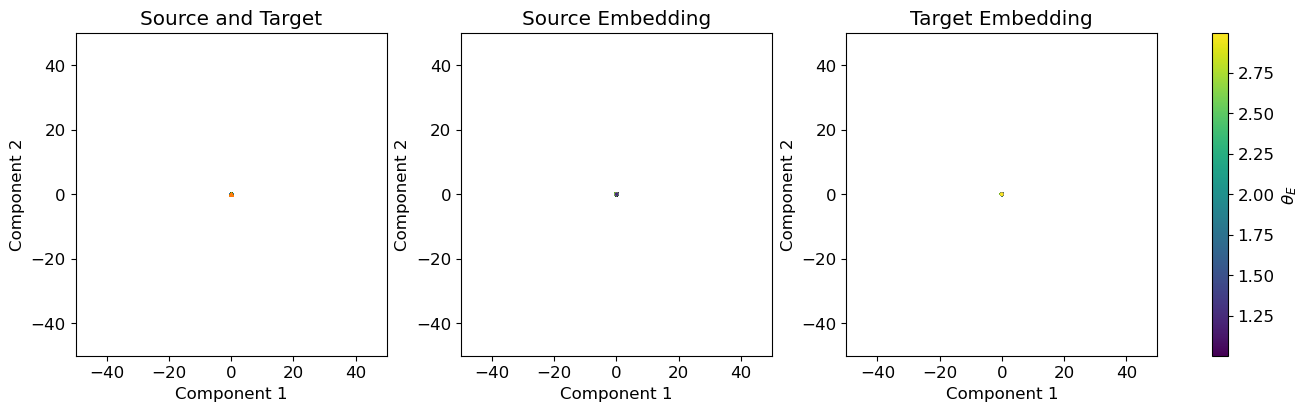

Saving Model... Done.
Saving Model SNLL... Done.

Epoch 100: 70.85s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0407
	Train Regression Loss: : 0.0052
	Train Mve Loss: : -0.1599
	Train R2 Score: : 0.9843
 Validation Statistics:
	Val Source Regression Loss: : 0.0051
	Val Target Regression Loss: : 0.0073
	Val Source R2 Score: : 0.9842
	Val Target R2 Score: : 0.9784
	Val Source Mve Loss: : -0.1486
	Val Target Mve Loss: : -0.1330
	Val Source Nll Loss: : -2.1284
	Val Target Nll Loss: : -1.9039

Epoch 101: 72.94s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0417
	Train Regression Loss: : 0.0128
	Train Mve Loss: : -0.1913
	Train R2 Score: : 0.9608
 Validation Statistics:
	Val Source Regression Loss: : 0.0154
	Val Target Regression Loss: : 0.0177
	Val Source R2 Score: : 0.9525
	Val Target R2 Score: : 0.9471
	Val Source Mve Loss: : -0.3249
	Val Target Mve Loss: : -0.3228
	Val Source Nll Loss: : -0.6252
	Val Target Nll Loss: : -0.6213

Ep

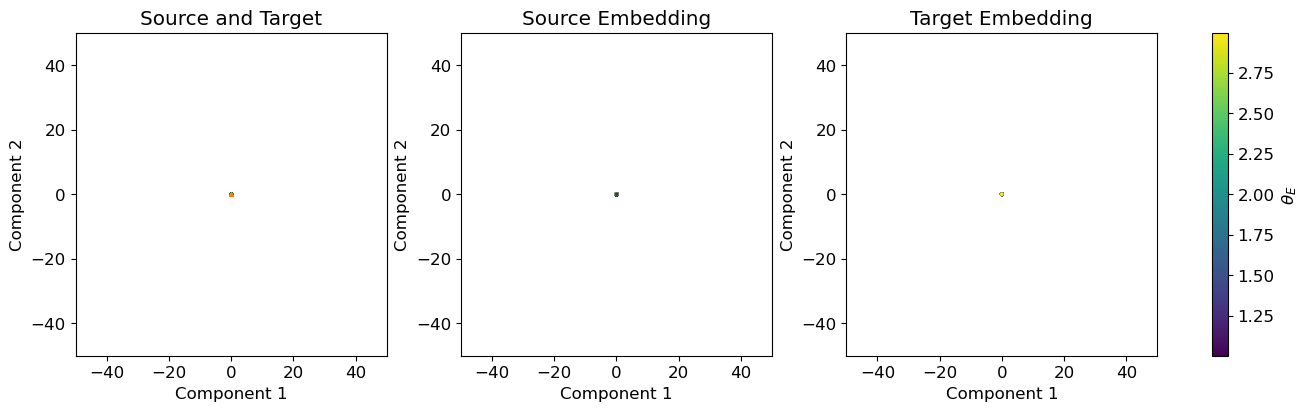

Saving Model... Done.

Epoch 120: 68.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0396
	Train Regression Loss: : 0.0054
	Train Mve Loss: : -0.1686
	Train R2 Score: : 0.9836
 Validation Statistics:
	Val Source Regression Loss: : 0.0059
	Val Target Regression Loss: : 0.0086
	Val Source R2 Score: : 0.9821
	Val Target R2 Score: : 0.9745
	Val Source Mve Loss: : -0.2275
	Val Target Mve Loss: : -0.2160
	Val Source Nll Loss: : -1.9275
	Val Target Nll Loss: : -1.8302

Epoch 121: 93.89s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0387
	Train Regression Loss: : 0.0070
	Train Mve Loss: : -0.2412
	Train R2 Score: : 0.9789
 Validation Statistics:
	Val Source Regression Loss: : 0.0044
	Val Target Regression Loss: : 0.0061
	Val Source R2 Score: : 0.9866
	Val Target R2 Score: : 0.9815
	Val Source Mve Loss: : -0.2473
	Val Target Mve Loss: : -0.2405
	Val Source Nll Loss: : -1.9164
	Val Target Nll Loss: : -1.8643

Epoch 122: 98.97s
-----------

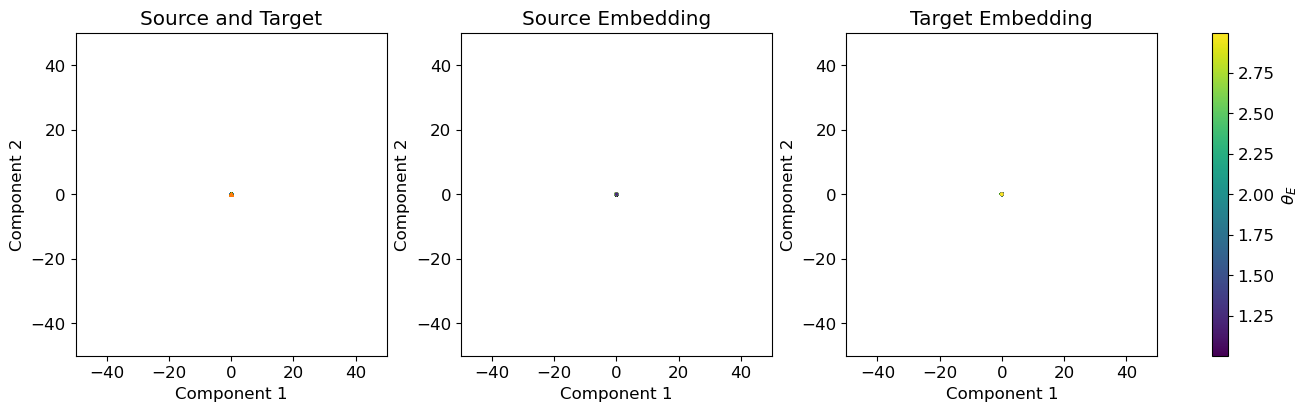

Saving Model... Done.

Epoch 140: 64.11s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0413
	Train Regression Loss: : 0.0056
	Train Mve Loss: : -0.1776
	Train R2 Score: : 0.9831
 Validation Statistics:
	Val Source Regression Loss: : 0.0043
	Val Target Regression Loss: : 0.0059
	Val Source R2 Score: : 0.9868
	Val Target R2 Score: : 0.9824
	Val Source Mve Loss: : -0.1598
	Val Target Mve Loss: : -0.1482
	Val Source Nll Loss: : -2.2171
	Val Target Nll Loss: : -2.0571

Epoch 141: 50.16s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0405
	Train Regression Loss: : 0.0053
	Train Mve Loss: : -0.1850
	Train R2 Score: : 0.9839
 Validation Statistics:
	Val Source Regression Loss: : 0.0045
	Val Target Regression Loss: : 0.0057
	Val Source R2 Score: : 0.9862
	Val Target R2 Score: : 0.9829
	Val Source Mve Loss: : -0.1730
	Val Target Mve Loss: : -0.1655
	Val Source Nll Loss: : -2.1727
	Val Target Nll Loss: : -2.0778

Epoch 142: 60.39s
-----------

In [11]:
print("Beginning Training...")

for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)
            
            print("Saving Model...", end = ' ')
            save_model(save_mod_name + "_{}".format(curr_epoch), model, optimizer, stats)
            print("Done.")

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_nll_loss'][-1] < best_nll_loss):
                print("Saving Model NLL...", end = ' ')
                nll_name = save_mod_name + "_nll"
                save_model(nll_name, model, optimizer, stats)
                best_nll_loss = stats['val_target_nll_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_source_nll_loss'][-1] < best_snll_loss):
                print("Saving Model SNLL...", end = ' ')
                snll_name = save_mod_name + "_snll"
                save_model(snll_name, model, optimizer, stats)
                best_snll_loss = stats['val_source_nll_loss'][-1]
                print("Done.")
        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)


        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        stats['val_source_nll_loss'].append(vals_validate[6])
        stats['val_target_nll_loss'].append(vals_validate[7])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        #stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [12]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

You can visualize the results below. We recommend using the `VisualizeModel.ipynb` notebook for more detailed visualization.

In [ ]:
# Loads a model for plotting/viz

viz_mod_name = save_mod_name#"models/papermve_v3_aug22_1315_C_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

In [ ]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

In [ ]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

In [ ]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

In [ ]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['val_source_nll_loss'], label = "Source Val NLL Loss")
plt.plot(eps, stats['val_target_nll_loss'], label = "Target Val NLL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-2, 1)

In [ ]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [ ]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.0))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | NLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [ ]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [ ]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

In [ ]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

In [ ]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()